In [1]:
import cppn
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import torch
from torch import nn
import torchvision.models as models
import pytorch_ssim

from PIL import Image
import imageio
from IPython.display import display, clear_output
import time
from datetime import datetime
from tqdm import tqdm

In [2]:
class SaveOutput:
    def __init__(self):        
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []
        
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        f = input.view(b, c, h*w) #bxcx(hxw)
        # torch.bmm(batch1, batch2, out=None)
        # batch1 : bxmxp, batch2 : bxpxn -> bxmxn
        G = torch.bmm(f, f.transpose(1, 2)) # f: bxcx(hxw), f.transpose: bx(hxw)xc -> bxcxc
        return G.div_(h*w)

In [3]:
vgg19 = models.vgg19(pretrained=True)
vgg_readout = vgg19.features[:29].cuda()

save_features = SaveOutput()
save_content = SaveOutput()

feature_layers = [1, 3, 5, 7, 11, 26]
content_layers = [19, 20, 21]
f_weights = [0.1] * len(feature_layers)
c_weights = [0] * len(content_layers)
multiplier = 1

weights = f_weights + c_weights
loss_layers = feature_layers + content_layers
layer_weights = torch.from_numpy(np.multiply(weights, multiplier)).float().cuda()

hook_handles = []
for i, layer in enumerate(vgg_readout.modules()):
    if i in feature_layers:
        handle = layer.register_forward_hook(save_features)
        hook_handles.append(handle)
    elif i in content_layers:
        handle = layer.register_forward_hook(save_content)
        hook_handles.append(handle)

In [4]:
net_size = [128, 64, 32, 16, 16, 8] 
dim_z = 16
dim_c = 3
print(net_size)

G = cppn.CPPN(net_size, dim_z, dim_c).cuda()
sampler = cppn.Sampler(G)

[128, 64, 32, 16, 16, 8]


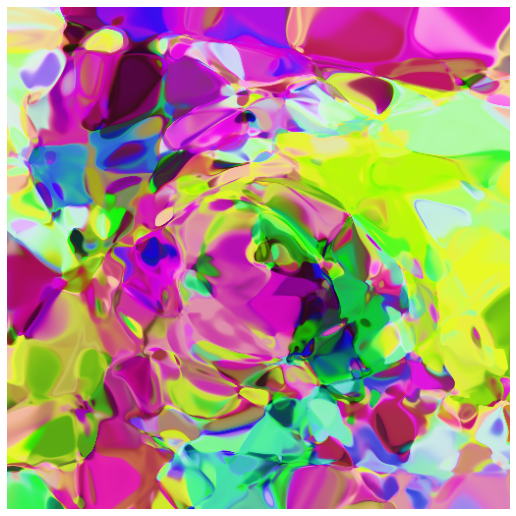

In [5]:
G.reinit(empty_cache=True)
gscale = 1
scale = 15
xres = 512
yres = 512
zscale = 4
nscale = 0

z =  torch.randn(1, dim_z).cuda()
delta_v = torch.randn(1, dim_z).cuda() 
z2 = z + 0.02*delta_v
coords = G._coordinates(scale*gscale,
                           xres, yres, z*zscale*gscale)

x = sampler.generate_img(G, z*zscale, scale, xres, yres, coords=coords)
sampler.imshow(x)

In [6]:
target_file = 'target/starry.jpg'
img = Image.open(target_file)
shape = np.array(img).shape
aspectratio = shape[0] / shape[1]
ssim_loss = pytorch_ssim.SSIM()

# get gran matrices from targets
with torch.no_grad():
    t_x = torch.from_numpy(x).float().cuda().permute(2, 0, 1).unsqueeze(0)
    vgg_target_out = vgg_readout(t_x * 255.0)    
    target_gram = [GramMatrix()(t) for t in save_features.outputs]
    save_features.clear()
    save_content.clear()

15900


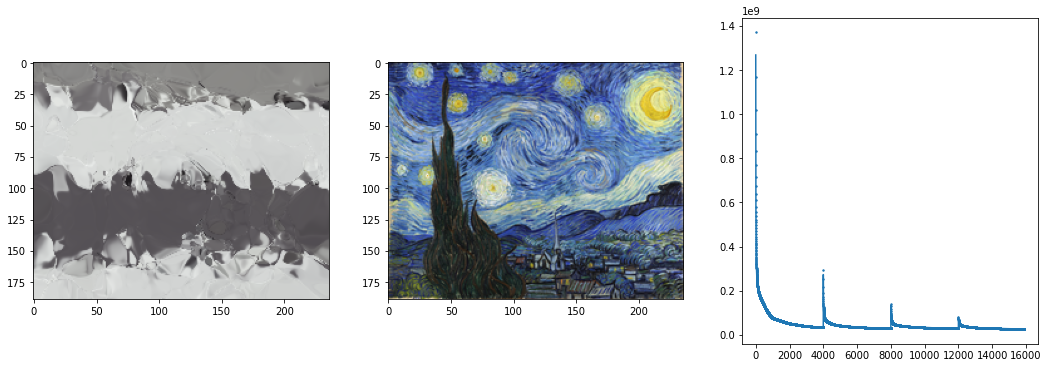

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [7]:
EPOCHS= 20000
XRES=224
YRES=int(XRES * aspectratio)
BATCH_SIZE=1

MASK_INDEX = 0

TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))
mask = torch.cuda.FloatTensor(TARGET[:, :, MASK_INDEX] > -1).reshape(-1)
mask = mask.unsqueeze(0).unsqueeze(-1)

TARGET = TARGET[:, :, :3].reshape(1, -1, 3).astype('float64')
TARGET = TARGET/TARGET.max()
TARGET = torch.cuda.FloatTensor(np.tile(TARGET, (BATCH_SIZE, 1, 1)))


G.train()

losses = []
var_z = 0.0 # variation in latent vector z across batch  

### FREEZE LAYERS
toggle_freeze = False
sparsity = 0.5

if toggle_freeze:    
    for m in G.rule.children():
        for l in m.children():
            if np.random.random() < sparsity:
                for p in l.parameters():
                    p.requires_grad = False
            else:
                for p in l.parameters():
                    p.requires_grad = True 

multiscale_target = False
big_factor = 0.8
change_target_time = 100
keep_full = True
num_full = 1


multiscale = False
scale_range = 1

scale_in = scale
zscale = zscale
# z = torch.randn(BATCH_SIZE, dim_z).cuda()
z_in = zscale * z.repeat(BATCH_SIZE, 1)


optim = torch.optim.Adam(G.parameters(), lr=1e-3)
# optim = torch.optim.LBFGS(, lr=1e-3)
lambda1 = lambda epoch: 1 / (1 + epoch // 1000)
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda1)
need_new_grid = True

for epoch in range(EPOCHS):
#     z_in = zscale * torch.randn(BATCH_SIZE, dim_z).cuda()

    
    delta_z = var_z*torch.randn(BATCH_SIZE, dim_z).cuda()
    zt = z_in + delta_z

    if need_new_grid:
        
        x = G._coordinates(scale_in, xres=XRES, yres=YRES, z=zt, batch_size=BATCH_SIZE)
        if multiscale_target:
            x, TARGET = cppn.multiscale_targets_apply(x, img, XRES, YRES, BATCH_SIZE, big_factor, keep_full, num_full)
        
        if multiscale and not multiscale_target: # both multiscaling can't be on at the same time
            scale_factor = 10**( scale_range * (np.random.uniform(size=BATCH_SIZE) - 1/2) )[:,  np.newaxis, np.newaxis]
            scale_factor = torch.from_numpy(scale_factor).float().cuda()
            x[0] = x[0]*scale_factor
            x[1] = x[1]*scale_factor
            x[2] = x[2]*torch.sqrt(scale_factor)
#             x[-1] = x[-1]*torch.from_numpy(scale_factor).float().cuda()
            x[-1] = x[-1]*scale_factor
            
        need_new_grid = False
    else:
        x = x[:-1]
        x.append(zt.unsqueeze(1))  # remove z layer inputs and replace with new z
        
        if multiscale:
#             x[-1] = x[-1]*torch.from_numpy(scale_factor).float().cuda()
            x[-1] = x[-1]*scale_factor
    
#     # get gran matrices from targets
#     with torch.no_grad():
#         vgg_target_out = vgg_readout(TARGET.view(-1, 3, XRES, YRES)*255.0)    
#         target_gram = [GramMatrix()(t) for t in save_output.outputs]
#         save_output.clear()        

    optim.zero_grad()
    out = G.forward(x, XRES, YRES)
    
    # get gram matrices for output image
    vgg_out = vgg_readout(out.view(-1, 3, XRES, YRES) * 255.0)
    out_gram = [GramMatrix()(o) for o in save_features.outputs]
    save_features.clear()
    save_content.clear()

    
    loss = [nn.MSELoss()(out_gram[i], target_gram[i]) * layer_weights[i] for i in range(len(out_gram))]
    loss.append(
        nn.MSELoss()(out.mean(2).reshape(BATCH_SIZE, YRES, XRES, 1) , TARGET.mean(2).reshape(-1, YRES, XRES, 1))
    )
    loss = sum(loss)

    loss.backward()
    optim.step()
    scheduler.step()
    
    losses.append(loss.item())
    
    if multiscale_target and epoch % change_target_time == 0:
        x = G._coordinates(scale_in, xres=XRES, yres=YRES, z=zt, batch_size=BATCH_SIZE)
        x, TARGET = cppn.multiscale_targets_apply(x, img, XRES, YRES, BATCH_SIZE, big_factor, keep_full, num_full)   
    
    if epoch % 100 == 0:
        alpha = 0.5
        rand_ind = 0
        nx = out[rand_ind].detach().cpu().numpy().reshape(YRES, XRES, -1)
        s_losses = alpha * np.array(losses[:-1]) + (1 - alpha) * np.array(losses[1:])

        plt.clf()
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        ax[0].imshow(nx)
        ax[2].plot(s_losses)
        ax[2].scatter(np.arange(len(losses)), losses, s=2)
#         ax[2].set_yscale('log')
        ax[1].imshow(TARGET[rand_ind].cpu().numpy().reshape(YRES, XRES, 3))
        clear_output(wait=True)
        print(f'{epoch}')
        display(plt.gcf())
        time.sleep(0.001)
        plt.close()
        
    if epoch % 4000 == 0 and epoch != 0:
        XRES += 4
        YRES += 4 
        need_new_grid = True
        
        TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))        
        mask = torch.cuda.FloatTensor(TARGET[:, :, MASK_INDEX] > 1e-5).reshape(-1)
        mask = mask.unsqueeze(0).unsqueeze(-1)
        
        TARGET = TARGET[:, :, :3].reshape(1, -1, 3).astype('float64')
        TARGET = TARGET/TARGET.max()
#         TARGET = torch.cuda.FloatTensor(np.tile(TARGET, (BATCH_SIZE, 1, 1)))
        TARGET = torch.cuda.FloatTensor(TARGET)
        

In [ ]:
p = list(G.parameters())
pg = [pi.grad for pi in p]

In [ ]:
x_reps = 10
y_reps = 10
x_dim = 512
y_dim = int(512 * aspectratio)

scale_hires = scale*gscale
z_hires = z*zscale*gscale
coords_hires = G._coordinates(scale_hires, x_reps*x_dim, y_reps*y_dim, z_hires, flatten=False)

x = sampler.generate_hires(G, z=z_hires, scale=scale, x_dim=x_dim, y_dim=y_dim, x_reps=x_reps, y_reps=y_reps, coords=coords_hires)
print(x.shape)
sampler.imshow(x)
  
time_str = datetime.now().strftime("%y-%m-%d-%H-%M-%S.%f")
figname = 'cppn/hi_res/' + time_str + '.png'
imageio.imwrite(figname, (x * 255).astype(np.uint8), format='png')

In [ ]:
 plt.imshow(TARGET.view(-1, YRES, XRES, 3).cpu().numpy()[0])

In [ ]:
out = vgg_readout(TARGET.view(-1, 3, YRES, XRES))

In [ ]:
out[0, i].shape

## Visualizing features in VGG19

### Target image features

In [ ]:
with torch.no_grad():
    save_output.clear()
    vgg_readout(TARGET.view(-1, 3, YRES, XRES))

r_idx = -1
readout_T = save_output.outputs[r_idx]

fig, axes = plt.subplots(10, 10, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(readout_T[0, i].detach().cpu().numpy())
    ax.set_axis_off()

### CPPN image featuers

In [ ]:
save_output.clear()
with torch.no_grad():
    im = G.forward(x, XRES, YRES)
    vgg_readout(im.view(-1, 3, YRES, XRES))

r_idx = -1
readout_G = save_output.outputs[r_idx]

fig, axes = plt.subplots(10, 10, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(readout_G[0, i].detach().cpu().numpy())
    ax.set_axis_off()

### Differences in features

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    diff = readout_T[0, i].detach().cpu().numpy() - readout_G[0, i].detach().cpu().numpy()
    ax.imshow(diff, vmin=-1, vmax=1)
    ax.set_axis_off()